In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym_bandits
import gym
import math

env = gym.make("BanditTenArmedGaussian-v0")

In [2]:
env.action_space

Discrete(10)

## Epsilon Greedy Policy

In [64]:
class EpsilonGreedyPolicy:
    def __init__(self):
        self.Q = self.initialize_zeros(10)
        self.sum_rewards = self.initialize_zeros(10)
        self.count = self.initialize_zeros(10)
    
    def initialize_zeros(self, num_arms):
        return np.zeros(num_arms)
    
    def epsilon_greedy(self, epsilon):
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else: 
            action = np.argmax(self.Q)  
        return action
    
    def pull_arm(self, num_rounds, epsilon):
        for i in range(num_rounds):
            
            # Select the arm using epsilon greedy
            arm = self.epsilon_greedy(epsilon)

            # Get the reward
            observation, reward, done, info = env.step(arm)

            # update the count of that arm
            self.count[arm] += 1

            # Sum the rewards obtained from the arm
            self.sum_rewards[arm]+=reward

            # calculate Q value which is the average rewards of the arm
            self.Q[arm] = self.sum_rewards[arm]/self.count[arm]
        
        print('Completed. The optimal arm is {}'.format(np.argmax(self.Q)))
    
    def check_Q(self):
        # print("The Q-values are:\n",self.Q)
        return self.Q
    
    def check_sum_rewards(self):
        # print("The rewards sum are:\n",self.sum_rewards)
        return self.sum_rewards
        
    def check_arm_count(self):
        # print("Counts of each arm:\n",self.count)
        return self.count

In [65]:
def random_play(arm):
    observation, reward, done, info = env.step(arm)
    print('Pull arm: ', arm)
    print('Observation: ', observation)
    print('Reward: ', reward)

In [73]:
num_epochs = 20000
epsilon_greedy_policy = EpsilonGreedyPolicy()
epsilon_greedy_policy.pull_arm(num_epochs, 0.9)
print()
Q_values = epsilon_greedy_policy.check_Q()
print("The Q-values are:\n",Q_values)
print()
rewards = epsilon_greedy_policy.check_sum_rewards()
print("The rewards sum are:\n", rewards)
print()
arm_count = epsilon_greedy_policy.check_arm_count()
print("Counts of each arm:\n", arm_count)
print()

Completed. The optimal arm is 3

The Q-values are:
 [ 0.29515509  0.20178608 -0.32846836  2.57834735 -0.22779266 -0.28418705
  0.76923205 -2.52409543  0.93944128  1.62677252]

The rewards sum are:
 [  531.57431101   370.88281741  -597.81241472  9679.11594472
  -417.7717443   -508.41064087  1351.54071166 -4548.41995796
  1737.0269249   2856.61254274]

Counts of each arm:
 [1801. 1838. 1820. 3754. 1834. 1789. 1757. 1802. 1849. 1756.]



In [74]:
def plot_arm_count(arm_count):
    x = np.arange(10)
    freq = arm_count
    width = 0.8 # width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, freq, width, color='g')

    ax.set_ylabel('Counts')
    ax.set_xlabel('Arm Index')
    plt.xticks(np.arange(0, 10, 1.0))

    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)

    plt.show()

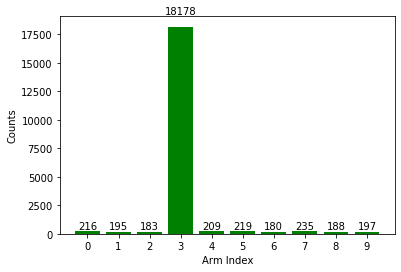

In [55]:
epsilon_greedy_policy.plot_arm_count(epsilon_greedy_policy.count)

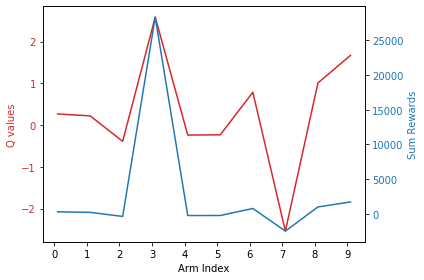

In [36]:
arm = np.arange(0.1, 10, 1)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Arm Index')
ax1.set_ylabel('Q values', color=color)
ax1.plot(arm, Q_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Sum Rewards', color=color) 
ax2.plot(arm, rewards, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.xticks(np.arange(0, 10, 1.0))
plt.show()

#### How does the epsilon values affect the final selection of optimal arm?

When epsilon =  0.1
Completed. The optimal arm is 3


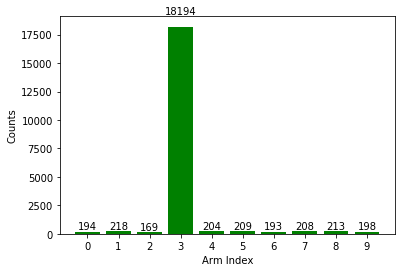

When epsilon =  0.3
Completed. The optimal arm is 3


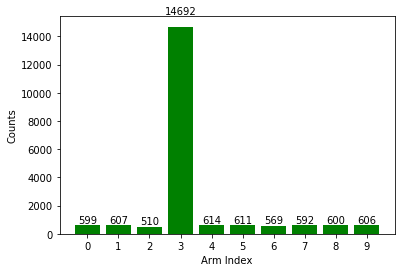

When epsilon =  0.6
Completed. The optimal arm is 3


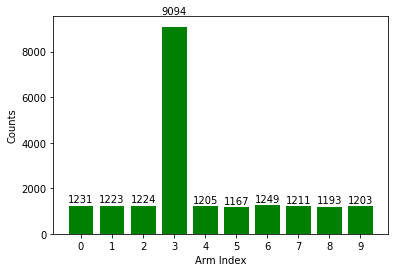

When epsilon =  0.9
Completed. The optimal arm is 3


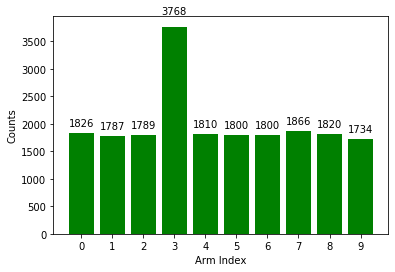

In [81]:
epsilon_values = [0.1, 0.3, 0.6, 0.9]
for ep in epsilon_values:
    print('When epsilon = ', ep)
    epsilon_greedy_policy = EpsilonGreedyPolicy()
    epsilon_greedy_policy.pull_arm(num_epochs, ep)
    arm_count = epsilon_greedy_policy.check_arm_count()
    plot_arm_count(arm_count)

#### Observation

1. The selection of optimal arm is always the same in the same game regardless the epsilon value. 
2. For epsilon value set at 0.1, it is follow greedy action which choose the arm that pay maximum reward. Therefore, the count of that arm selected is highest.
2. When epsilon value increased, all other non-best arms are also have been selected due to high exploration rate. Therefore, the count of that arm selected is increased.

## Softmax Exploration Policy

In [11]:
class SoftmaxExploration:
    def __init__(self):
        self.Q = self.initialize_zeros(10)
        self.sum_rewards = self.initialize_zeros(10)
        self.count = self.initialize_zeros(10)

    def initialize_zeros(self, num_arms):
        return np.zeros(num_arms)
    
    def softmax_probability(self, tau):
        total = sum([math.exp(val/tau) for val in self.Q])
        probs = [math.exp(val/tau)/total for val in self.Q]
        threshold = np.random.random()
        cumulative_prob = 0.0

        for i in range(len(probs)):
            cumulative_prob += probs[i]
            if (cumulative_prob > threshold):
                return i
        return np.argmax(probs)
    
    def pull_arm(self, num_rounds):
        for i in range(num_rounds):
            
            # Select the arm using softmax
            arm = self.softmax_probability(0.5)
            observation, reward, done, info = env.step(arm)
            self.count[arm] += 1
            self.sum_rewards[arm]+=reward
            self.Q[arm] = self.sum_rewards[arm]/self.count[arm]
        
        print('Completed. The optimal arm is {}'.format(np.argmax(self.Q)))
    
    def check_Q(self):
        print("The Q-values are:\n",self.Q)
    
    def check_sum_rewards(self):
        print("The rewards sum are:\n",self.sum_rewards)
        
    def check_arm_count(self):
        print("Counts of each arm:\n",self.count)
        
    def plot_arm_count(self, arm):
        x = np.arange(10)
        freq = arm
        width = 0.8 # width of the bars
        fig, ax = plt.subplots()
        rects1 = ax.bar(x, freq, width, color='m')

        ax.set_ylabel('Counts')
        ax.set_xlabel('Arm')
        plt.xticks(np.arange(0, 10, 1.0))

        def autolabel(rects):
            # attach some text labels
            for rect in rects:
                height = rect.get_height()
                ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                        '%d' % int(height),
                        ha='center', va='bottom')

        autolabel(rects1)
        plt.show()

In [12]:
num_epochs = 20000
softmax_policy = SoftmaxExploration()
softmax_policy.pull_arm(num_epochs)
print()
softmax_policy.check_Q()
print()
softmax_policy.check_sum_rewards()
print()
softmax_policy.check_arm_count()

Completed. The optimal arm is 3

The Q-values are:
 [ 0.21472437  0.18430432 -0.36192073  2.59059015 -0.13535974 -0.72845301
  0.79352772 -4.11985361  0.96320192  1.66458103]

The rewards sum are:
 [ 3.62884190e+01  2.19322146e+01 -1.48387501e+01  4.22007136e+04
 -9.06910242e+00 -3.64226503e+00  2.91224672e+02 -4.11985361e+00
  5.36503467e+02  3.96836118e+03]

Counts of each arm:
 [1.690e+02 1.190e+02 4.100e+01 1.629e+04 6.700e+01 5.000e+00 3.670e+02
 1.000e+00 5.570e+02 2.384e+03]


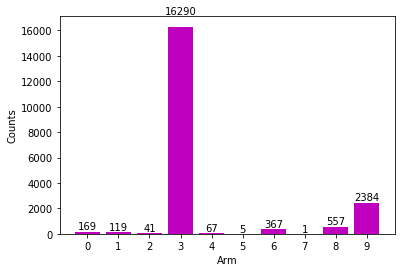

In [13]:
softmax_policy.plot_arm_count(softmax_policy.count)

In [ ]:
class UpperConfidenceBound:
    def __init__(self):
        self.Q = self.initialize_zeros(10)
        self.sum_rewards = self.initialize_zeros(10)
        self.count = self.initialize_zeros(10)

    def initialize_zeros(self, num_arms):
        return np.zeros(num_arms)
    
    def softmax_probability(self, tau):
        total = sum([math.exp(val/tau) for val in self.Q])
        probs = [math.exp(val/tau)/total for val in self.Q]
        threshold = np.random.random()
        cumulative_prob = 0.0

        for i in range(len(probs)):
            cumulative_prob += probs[i]
            if (cumulative_prob > threshold):
                return i
        return np.argmax(probs)
    
    def pull_arm(self, num_rounds):
        for i in range(num_rounds):
            
            # Select the arm using softmax
            arm = self.softmax_probability(0.5)
            observation, reward, done, info = env.step(arm)
            self.count[arm] += 1
            self.sum_rewards[arm]+=reward
            self.Q[arm] = self.sum_rewards[arm]/self.count[arm]
        
        print('Completed. The optimal arm is {}'.format(np.argmax(self.Q)))
    
    def check_Q(self):
        print("The Q-values are:\n",self.Q)
    
    def check_sum_rewards(self):
        print("The rewards sum are:\n",self.sum_rewards)
        
    def check_arm_count(self):
        print("Counts of each arm:\n",self.count)
        
    def plot_arm_count(self, arm):
        x = np.arange(10)
        freq = arm
        width = 0.8 # width of the bars
        fig, ax = plt.subplots()
        rects1 = ax.bar(x, freq, width, color='m')

        ax.set_ylabel('Counts')
        ax.set_xlabel('Arm')
        plt.xticks(np.arange(0, 10, 1.0))

        def autolabel(rects):
            # attach some text labels
            for rect in rects:
                height = rect.get_height()
                ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                        '%d' % int(height),
                        ha='center', va='bottom')

        autolabel(rects1)
        plt.show()

In [32]:
def UCB(iters):
    
    ucb = np.zeros(10)
    
    # check if consists at least 10 sample
    if iters < 10:
        return i 
    else:
        for arm in range(10):
            # calculate upper bound
            upper_bound = math.sqrt((2*math.log(sum(count))) / count[arm])
            
            # add upper bound to the Q value
            ucb[arm] = Q_UCB[arm] + upper_bound
        
    # return the arm which has maximum value
    return (np.argmax(ucb))

In [33]:
for i in range(num_rounds):
    
    # Select the arm using UCB
    arm = UCB(i)

    observation, reward, done, info = env.step(arm)
    
    # update the count of that arm
    count[arm] += 1
    
    # Sum the rewards obtained from the arm
    sum_rewards[arm]+=reward
    
    # calculate Q value which is the average rewards of the arm
    Q_UCB[arm] = sum_rewards[arm]/count[arm]
    
print( 'The optimal arm is {}'.format(np.argmax(Q)))

The optimal arm is 0


In [39]:
def thompson_sampling(alpha,beta):
    samples = [np.random.beta(alpha[i]+1,beta[i]+1) for i in range(10)]
    return np.argmax(samples)

for i in range(num_rounds):

    arm = thompson_sampling(alpha,beta)

    observation, reward, done, info = env.step(arm)

    count[arm] += 1

    sum_rewards[arm]+=reward

    Q[arm] = sum_rewards[arm]/count[arm]
    
    # If it is a positive reward increment alpha
    if reward >0:
        alpha[arm] += 1
    # If it is a negative reward increment beta
    else:
        beta[arm] += 1

print( 'The optimal arm is {}'.format(np.argmax(Q)))

The optimal arm is 0


In [16]:
for i in range(num_rounds):

    # arm using epsilon greedy
    arm = epsilon_greedy(0.5)
    
    # arm using softmax
    arm = softmax(0.5)

    observation, reward, done, info = env.step(arm)

    count[arm] += 1

    sum_rewards[arm]+=reward

    # calculate Q value which is the average rewards of the arm
    Q[arm] = sum_rewards[arm]/count[arm]
    
print( 'The optimal arm is {}'.format(np.argmax(Q)))

The optimal arm is 4


In [18]:
Q

array([ 1.19831264,  0.33350828,  0.76601153, -0.3355797 ,  2.0204708 ,
       -0.98286558,  1.66036175, -0.47403209,  0.23711068, -0.55311812])